## Project outline

Our goal is to predict the future healthcare costs of a region based on following predictors: population structure, alchohol and tobacco consumption and drug use, level of education and employment (possible to add others). Net expenditure means the costs after all revenue has been taken into account.

# The data

Our data was obtained from Finnish Statistical center and Finnish Institute of Health and Welfare.

First let us load and look at the data:

In [73]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [74]:
# Total population of region by year and gender
pop_total = pd.read_csv("data/pop_by_region.csv", sep=";", header=None, 
                         names=["category", "id", "region", "area_code", "gender", "year", "count", "pop_total"])

pop_total = pop_total[["region", "gender", "year", "pop_total"]]
pop_total = pop_total[np.where(pop_total["gender"] == "combined", True, False)]
pop_total = pop_total.drop(columns=["gender"])

# Total municipal health expenditure (euro per capita) by region and year
health_cost = pd.read_csv("data/health_per_capita.csv", sep=";", header=None, index_col=False,
                            names=["category", "id", "region", "area_code", "gender", "year", "health_cost"])

health_cost = health_cost[["region", "year", "health_cost"]]

data = pd.merge(pop_total, health_cost, how="inner", on=["year", "region"])
data.head()

,region,year,pop_total,health_cost
0,Central Finland,1993,258485,2753.7
1,Central Finland,1994,259392,2656.4
2,Central Finland,1995,259778,2833.8
3,Central Finland,1996,260835,2943.6
4,Central Finland,1997,261559,2690.9


Above we have data on total population by year, region and gender. The other data set contains total operating net expenditure of municipal health care, euro per capita.

First, in population data we remove unnecessary columns and rows where "Gender" is not "combined". This gives us a data frame with total population, both men and women combined, by year and region. Then we merge this with healthcare data, obtaining a frame with net health expenditure and population by region and year.

In [75]:
# Population structure as total numbers and percentages by region, year and ages
pop_structure = pd.read_csv("data/pop_structure_orig.csv", sep=";", header=None,
                                    names=["category", "id", "region", "area_code", "gender", "year", "percentage", "total"])

pop_structure = pop_structure[["category", "region", "gender", "year", "percentage", "total"]]

# Filter out unnecessary categories:
pop_structure = pop_structure[(pop_structure["category"] == "Population aged 0-18 as % of total population") 
                              | (pop_structure["category"] == "Population aged 18-64 as % of total population")
                              | (pop_structure["category"] == "Population aged 65 and over as % of total population")]

# Create new columns male_0_18, male_18_64, male_65, female_0_18, female_18_64, female_65, combined_0_18, combined_18_64, combined_65
pop_structure["male_0_18"] = np.where((pop_structure["category"] == "Population aged 0-18 as % of total population") 
                                      & (pop_structure["gender"] == "male"), pop_structure["total"], 0)

pop_structure["male_18_64"] = np.where((pop_structure["category"] == "Population aged 18-64 as % of total population") 
                                      & (pop_structure["gender"] == "male"), pop_structure["total"], 0)

pop_structure["male_65"] = np.where((pop_structure["category"] == "Population aged 65 and over as % of total population") 
                                      & (pop_structure["gender"] == "male"), pop_structure["total"], 0)

pop_structure["female_0_18"] = np.where((pop_structure["category"] == "Population aged 0-18 as % of total population") 
                                      & (pop_structure["gender"] == "female"), pop_structure["total"], 0)

pop_structure["female_18_64"] = np.where((pop_structure["category"] == "Population aged 18-64 as % of total population") 
                                      & (pop_structure["gender"] == "female"), pop_structure["total"], 0)

pop_structure["female_65"] = np.where((pop_structure["category"] == "Population aged 65 and over as % of total population") 
                                      & (pop_structure["gender"] == "female"), pop_structure["total"], 0)

pop_structure["combined_0_18"] = np.where((pop_structure["category"] == "Population aged 0-18 as % of total population") 
                                      & (pop_structure["gender"] == "combined"), pop_structure["total"], 0)

pop_structure["combined_18_64"] = np.where((pop_structure["category"] == "Population aged 18-64 as % of total population") 
                                      & (pop_structure["gender"] == "combined"), pop_structure["total"], 0)

pop_structure["combined_65"] = np.where((pop_structure["category"] == "Population aged 65 and over as % of total population") 
                                      & (pop_structure["gender"] == "combined"), pop_structure["total"], 0)

# Drop percentage, total, gender and category, group by year and region and obtain sum
pop_structure = pop_structure.drop(columns=["category", "gender", "percentage", "total"])
pop_structure = pop_structure.groupby(["region", "year"], as_index=False).sum()

# Merge with previous data
data = pd.merge(pop_structure, data, how="inner", on=["year", "region"])
data.head()

,region,year,male_0_18,male_18_64,male_65,female_0_18,female_18_64,female_65,combined_0_18,combined_18_64,combined_65,pop_total,health_cost
0,Central Finland,1993,33139,82320,13731,31514,78184,23034,64653,160504,36765,258485,2753.7
1,Central Finland,1994,32988,82406,14113,31524,78412,23429,64512,160818,37542,259392,2656.4
2,Central Finland,1995,32715,82518,14473,31322,78565,23728,64037,161083,38201,259778,2833.8
3,Central Finland,1996,32563,82863,14887,31092,78943,24042,63655,161806,38929,260835,2943.6
4,Central Finland,1997,32311,83018,15197,30859,79184,24347,63170,162202,39544,261559,2690.9


Here we have population structure data. The data set contained many options, but we chose to split the population by gender and ages 0-18, 18-64 and 65 and over. This would yield 9 new predictors: for each of the age categories we have men, women and combined population. First we created those columns and then grouped by region and year and summed the values to get all observations into one row. Next we will merge some data on education and employment into the data frame.

In [76]:
# load data, drop unnecessary column 
edu = pd.read_csv("data/education.csv", sep=';', header=None).drop(columns=[0, 1, 3, 7])
edu.columns = ["region", "sex", "year", "length of education per person"]

edu_pivot = edu.pivot_table(index=['region', 'year'], columns='sex', values='length of education per person').reset_index()

edu_pivot.rename(columns={'combined': 'combined_length_education', 'female': 'female_length_education', 'male': 'male_length_education'}, inplace=True)
# only select relevant columns
edu_pivot = edu_pivot[['region', 'year', 'male_length_education', 'female_length_education', 'combined_length_education']]


data = pd.merge(edu_pivot, data, how="inner", on=["year", "region"])
data.head()

,region,year,male_length_education,female_length_education,combined_length_education,male_0_18,male_18_64,male_65,female_0_18,female_18_64,female_65,combined_0_18,combined_18_64,combined_65,pop_total,health_cost
0,Central Finland,1993,236.0,226.9,231.3,33139,82320,13731,31514,78184,23034,64653,160504,36765,258485,2753.7
1,Central Finland,1994,240.0,233.0,236.4,32988,82406,14113,31524,78412,23429,64512,160818,37542,259392,2656.4
2,Central Finland,1995,244.8,239.1,241.9,32715,82518,14473,31322,78565,23728,64037,161083,38201,259778,2833.8
3,Central Finland,1996,249.4,245.4,247.4,32563,82863,14887,31092,78943,24042,63655,161806,38929,260835,2943.6
4,Central Finland,1997,254.3,251.8,253.0,32311,83018,15197,30859,79184,24347,63170,162202,39544,261559,2690.9


Data source: Educational structure of population (Statistics Finland). The level of education is described by length of education per person. For example, the value 246 shows that the theoretical length of education per person is 2.5 years after completing basic education (what is the unit? A month? Is basic education considered to be until 18?). 

In [77]:
# read employment data 
""" employment = pd.read_csv("data/employment.csv", sep=';', header=None)
employment = employment.drop(columns=[1, 3, 7])
employment.columns = ["status", "region", "sex", "year", "percentage"]

employment_pivot = employment.pivot_table(
    index=['region', 'year'],
    columns=['sex', 'status'],
    values='percentage'  
)

employment_pivot.columns = [f"{sex}_{status}" for sex, status in employment_pivot.columns]
employment_pivot.reset_index(inplace=True)

employment_pivot = employment_pivot[['region', 'year',
                                     'male_Employed, as % of total population', 'male_Students, as % of total population', 
                                     'female_Employed, as % of total population', 'female_Students, as % of total population',
                                     'combined_Employed, as % of total population', 'combined_Students, as % of total population',]]


data = pd.merge(employment_pivot, data, how="inner", on=["year", "region"])
data.head() """

' employment = pd.read_csv("data/employment.csv", sep=\';\', header=None)\nemployment = employment.drop(columns=[1, 3, 7])\nemployment.columns = ["status", "region", "sex", "year", "percentage"]\n\nemployment_pivot = employment.pivot_table(\n    index=[\'region\', \'year\'],\n    columns=[\'sex\', \'status\'],\n    values=\'percentage\'  \n)\n\nemployment_pivot.columns = [f"{sex}_{status}" for sex, status in employment_pivot.columns]\nemployment_pivot.reset_index(inplace=True)\n\nemployment_pivot = employment_pivot[[\'region\', \'year\',\n                                     \'male_Employed, as % of total population\', \'male_Students, as % of total population\', \n                                     \'female_Employed, as % of total population\', \'female_Students, as % of total population\',\n                                     \'combined_Employed, as % of total population\', \'combined_Students, as % of total population\',]]\n\n\ndata = pd.merge(employment_pivot, data, how="inner",

The employment situation is described by the proportion of students and employed individuals to the total population.

In [78]:
# alchohol data, as litres of pure alcohol sold per capita
alcohol = pd.read_csv("data/alcohol_sales.csv", sep=";", header=None).drop(columns=[0, 1, 3, 4, 7])
alcohol.columns = ["region", "year", "alcohol_sales"]

data = pd.merge(alcohol, data, how="inner", on=["year", "region"])
data.head()

,region,year,alcohol_sales,male_length_education,female_length_education,combined_length_education,male_0_18,male_18_64,male_65,female_0_18,female_18_64,female_65,combined_0_18,combined_18_64,combined_65,pop_total,health_cost
0,Central Finland,1993,6.5,236.0,226.9,231.3,33139,82320,13731,31514,78184,23034,64653,160504,36765,258485,2753.7
1,Central Finland,1994,6.3,240.0,233.0,236.4,32988,82406,14113,31524,78412,23429,64512,160818,37542,259392,2656.4
2,Central Finland,1995,6.5,244.8,239.1,241.9,32715,82518,14473,31322,78565,23728,64037,161083,38201,259778,2833.8
3,Central Finland,1996,6.7,249.4,245.4,247.4,32563,82863,14887,31092,78943,24042,63655,161806,38929,260835,2943.6
4,Central Finland,1997,6.7,254.3,251.8,253.0,32311,83018,15197,30859,79184,24347,63170,162202,39544,261559,2690.9


In [79]:
data.to_csv("data/data_merged.csv")

## Data processing

The data contains some categorical variables, like gender, which need to be converted to numeric values. Additionally, the data needs to be merged into one data frame by year and region. 

## Exploratory data analysis

Map of Finland: 

<Axes: >

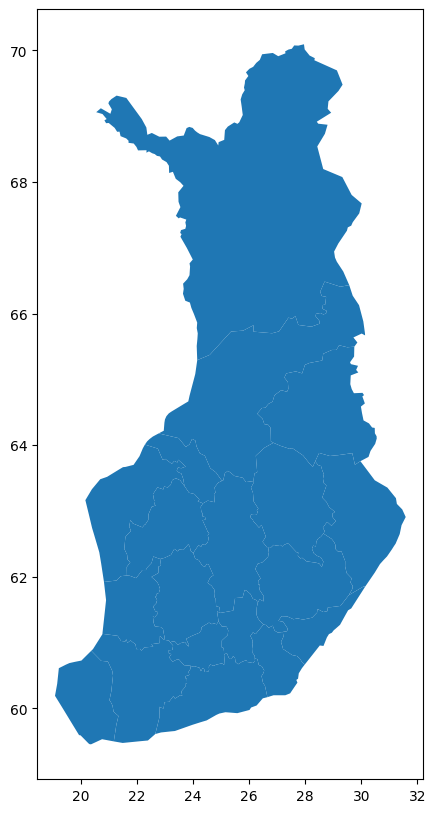

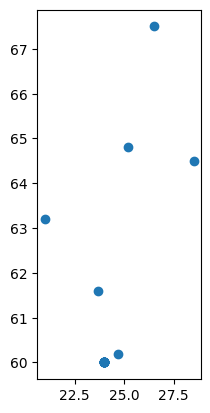

In [80]:
finland_map = gpd.read_file("data/regions.geojson")
finland_map['geometry'].plot(figsize=(10, 10))

finland_points = gpd.read_file("data/regions_centers.geojson")
finland_points['geometry'].plot()


Some scatter plots to see the relationships between predictors:

In [81]:
plt.scatter()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'